# Robert Bubble Test ｡˚○

<div class="alert alert-block alert-success">

## Part 1: Problem Set Up 

While in Straka we followed a **cold** bubble's descent through the atmosphere, in our second tutorial, we will instead simulate a **hot** air bubble rising and its resultant [Kelvin-Helmholtz instability](https://en.wikipedia.org/wiki/Kelvin%E2%80%93Helmholtz_instability). 

The Robert rising bubble test, developed by [Robert et al. (1993)](https://ui.adsabs.harvard.edu/abs/1993JAtS...50.1865R), and is another standard benchmark test of non-hydrostatic numerical models. 

While many of the setting for this problem are similar to Straka, there are some key differences that we will be covering in the following tutorials. 

Additionally, we will show how to continue a simulation from a `.restart` file. 

</div>

<img src="../../images/robert-theta.png">

<div class="alert alert-info">

## The Problem

In simple terms, the Robert problem involves: 

1. A background 2-dimensional, ideal-gas atmosphere that is an adiabat with a surface temperature of 303.15K, and surface pressure of 1 bar.

2. A parcel of gas (a bubble) is defined, at the bottom of the simulation, with a maximum temperature difference of +0.5K. 

As described in the Straka tutorial, in $\texttt{PADDLE}$, we must find a way to define the initial problem as described above with **primitive variables**.

</div>


<div class="alert alert-warning">

For a review on properties of an ideal gas, see the **Straka Tutorial (Part 1)**

</div>

In [1]:
# Lets define the two properties needed for an ideal gas 

# gammad is the adiabatic index
# 1.4 for diatomic gasses (N, O, Air)
gammad = 1.4 

# molecular weight (kg/mol)
# This is the molecular weight of Earth's atmosphere 
weight = 29.3e-3 # in kg/mol

<div class="alert alert-info">

## Setting Up the Initial Problem Conditions

Now lets figure out how to set up the actual properties of the bubble in the simulation, and the atmosphere surrounding it. 

The bubble's spatial definition will be identical to the Straka bubble, however, we will the temperature anomaly a bit differently. 

</div>

#### Bubble's spatial intialization

<div class="alert alert-warning">

This time, our bubble will be a **sphere** (instead of the ellipse found in Straka).

By definition, the strict boundaries of the bubble will exist wherever the elliptical distance (*r*) is less than the radius (*a*), where 

$r = ((x-x_c)^2+(z-z_c^2)^{2}$

where *x_c* and *z_c* are the center coordinate of the bubble.

</div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Lets first define our simulation grid space 

# Here we define a simulation that is 1.5 km high and 1 km wide
# with a spatial resolution of 5 meters 

# x1 = Height (often denoted with 'z')
x1min = 0
x1max = 1.5e3 # in meters

# nx1 = Number of Cells in Height Dimension
nx1 = 300  # 1500/5 = 300

# x2 = Width (often denoted with 'x')
x2min = 0
x2max = 1.0e3 # in meters

# nx2 = Number of Cells in Width Dimension 
nx2 = 200 # 1000/5 = 200

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.5))

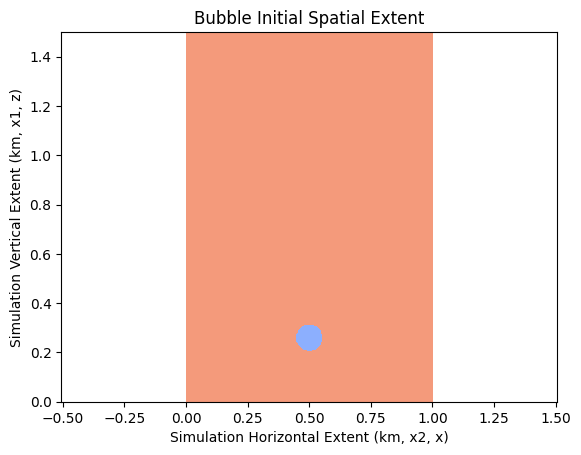

In [4]:
# Center of the bubble is at height of 0.26 km, 
# and center of simulation 0.5 km

zc = 260 # height of center, in meters
xc = 500   # left/right of center, in meters

# Radius of the circle 
a = 50 # radius, in meters

# Lets plot the bubble's spatial extent 

# Simulation domain as defined in cell above
# Note that x1 (z) is height 
# and that x2  (x) is width 
z_array = np.linspace(x1min, x1max, nx1)
x_array = np.linspace(x2min, x2max, nx2)

# Create meshgrid in order to plot 
Z, X = np.meshgrid(z_array, x_array)

# Circular distance, as defined above
r = (((X-xc)**2) + (((Z-zc))**2))**0.5

# Add the mask L < 1 (which defines the spatial extent of the bubble)
# Divide X and Z by 1000 to get km instead of m 
plt.contourf(X/1000,Z/1000, r < a, cmap = 'coolwarm_r')
plt.title('Bubble Initial Spatial Extent')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (km, x1, z)')
plt.axis('equal') # To show the bubble is circular 

#### Bubble's temperature anomaly initialization

We will then want to define some sort of temperature distribution. 

Unlike Straka's defined temperature distribution, we will want a slightly different one where the core of the bubble (defined to the radius, *a*) is a single temperature anomaly, and the outside of the bubble has a gradient. 

<div class="alert alert-warning">

$$
\Delta T = \begin{cases}
    0.5 K & \text{if } r < a \\
    0.5 e^{\frac{-(r-a)^2}{s^2}} & \text{if } r > a\\
\end{cases}
$$

The temperature difference between the bubble and its surrounding atmosphere, $\Delta T$, is known as the temperature anomaly. 

</div>

Lets plot what this looks like: 

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.5))

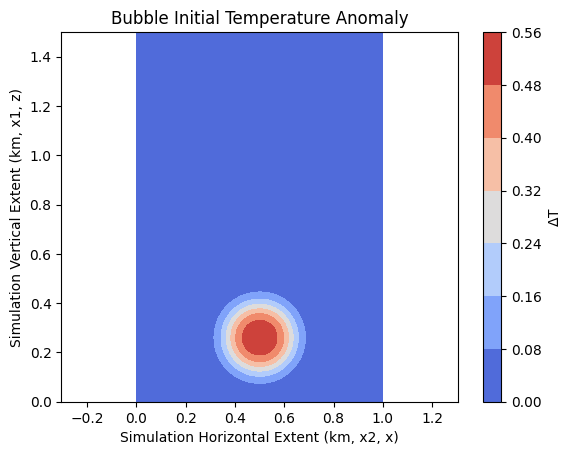

In [5]:
# Maximum temperature difference from surrounding atmosphere
dT = 0.5 # in Kelvin 

# Width of the temperature distribution outside of the bubble 
s = 100

# Temperature anomaly 
# Where r<a (within bounds of bubble) it is dT, otherwise, compute the exponential 
delta_T = np.where(r < a, dT, dT*np.exp((-(r-a)**2)/(s**2)))

# Plot with delta_T as colormap 
plt.contourf(X/1000,Z/1000, delta_T, cmap = 'coolwarm')
plt.title(r'Bubble Initial Temperature Anomaly')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (km, x1, z)')
plt.colorbar(label = r'$\Delta$T')
plt.axis('equal') # To show the bubble is circular 

We can also plot what the temperature gradient looks like across the whole bubble

Text(0.5, 1.0, '$\\Delta$T across slice of Bubble')

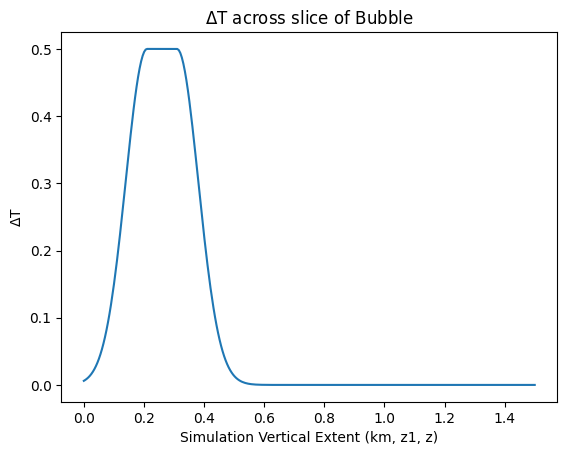

In [6]:
delta_T_at_05_km = delta_T[100]

plt.plot(z_array/1000, delta_T_at_05_km)
plt.xlabel('Simulation Vertical Extent (km, z1, z)')
plt.ylabel(r'$\Delta$T')
plt.title(r'$\Delta$T across slice of Bubble')

#### Deriving initial temperature, pressure, and density of entire simulation domain

Following the steps we took in the Straka bubble case, we can determine the temperature profile of the atmosphere since it is an ideal gas, the simulation is adiabatic, and we know the pressure-temperature at the surface. 

<div class="alert alert-warning">
The dry adiabatic lapse rate (i.e., how temperature changes with altitude) for an ideal gas is 

$\frac{dT}{dz} = -\frac{g}{c_p}$ 
</div>

In [7]:
# Gravity (Earth's gravity)
gravity = 9.8

In [8]:
# Thermodynamic constants 

# Specific gas constant
Rd = (8.314/weight)

# Specific heat capacity at constant pressure
# This is the other equation to compute c_p, without c_v
cp = gammad / (gammad - 1.0) * Rd

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.5))

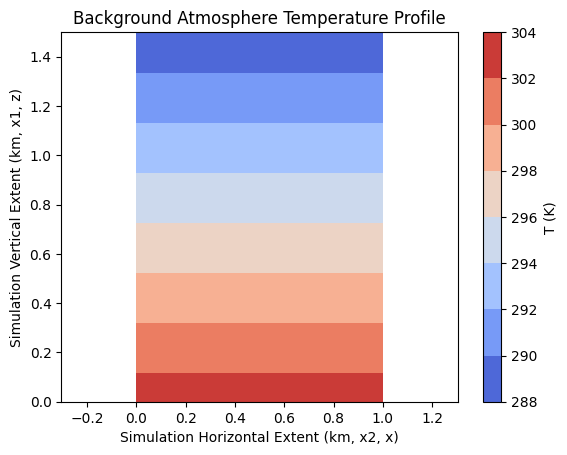

In [9]:
# Dry adiabatic lapse rate for ideal gas
dT_dz = -gravity/cp # K per m 

# Surface temperature is 303.15K 
# As defined in the problem statement above
Ts = 303.15 

# Ps is the surface pressure
# 1 bar = 1e5 pascals 
# We'll need this later!
Ps = 1e5

# T = Initial Temperature + (lapse rate * altitude array)
T_array = Ts + (dT_dz*Z)

# Plot temperature w/ height 
plt.contourf(X/1000,Z/1000, T_array, cmap = 'coolwarm')
plt.title(r'Background Atmosphere Temperature Profile')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (km, x1, z)')
plt.colorbar(label = r'T (K)')
plt.axis('equal') # To show rectangular dimensions of simulation

We can now apply the temperature anomaly of the bubble to the atmosphere

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.5))

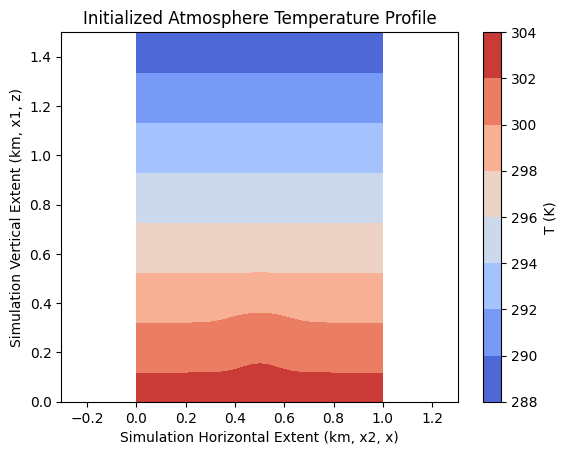

In [10]:
# Temperature array + temperature anomaly array 
plt.contourf(X/1000,Z/1000, T_array + delta_T, cmap = 'coolwarm')
plt.title(r'Initialized Atmosphere Temperature Profile')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (km, x1, z)')
plt.colorbar(label = r'T (K)')
plt.axis('equal') # To show rectangular dimensions of simulation

<div class="alert alert-info">

## Setting Up the Initial Problem Conditions w/ Primitive Variables

Now that we've set up the problem in both space and temperature, lets figure out how to turn it into an initial condition in terms of **primitive variables**.

As we did in Straka, we set up the pressure **before** we apply the temperature anomaly of the bubble. 

We do this since pressure equilibrates at the speed of sound (so the pressure inside the bubble is the same as pressure outside the bubble).

The pressure of our atmosphere is given by 

<div class="alert alert-warning">

$P = P_s (\frac{T}{T_s})^\frac{c_p}{R_d}$

where $P_s$ and $T_s$ is the surface pressure and temperature.

</div>


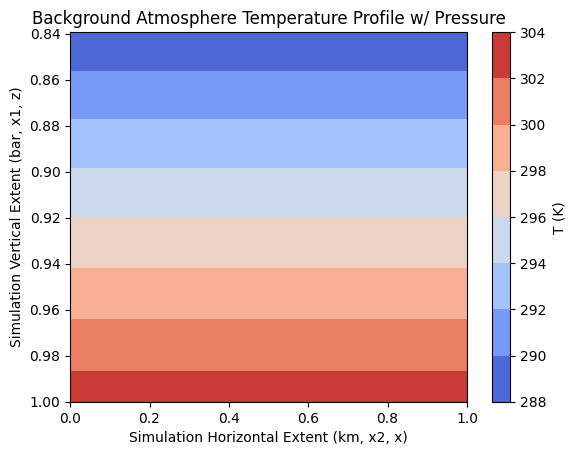

In [11]:
P = Ps*((T_array/Ts)**(cp/Rd))

# Plot pressure in bars on y-axis
plt.contourf(X/1000,P/1e5, T_array, cmap = 'coolwarm')
plt.gca().invert_yaxis()
plt.title(r'Background Atmosphere Temperature Profile w/ Pressure')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (bar, x1, z)')
plt.colorbar(label = r'T (K)')

We can now apply the temperature anomaly to the atmosphere: 

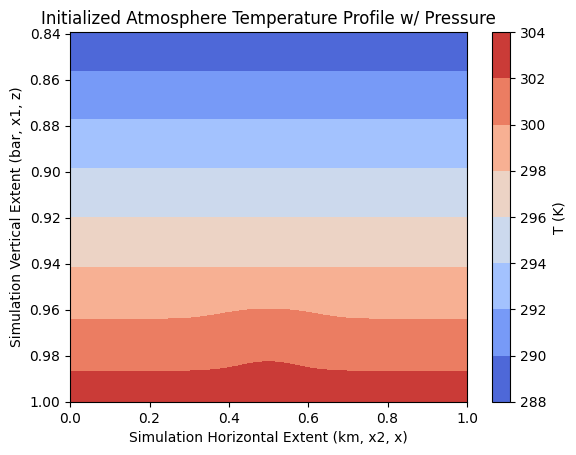

In [12]:
P = Ps*((T_array/Ts)**(cp/Rd))
# Note, we still keep Pressure initialized without the temperature anomaly! 

# Plot pressure in bars on y-axis
plt.contourf(X/1000,P/1e5, T_array+delta_T, cmap = 'coolwarm')
plt.gca().invert_yaxis()
plt.title(r'Initialized Atmosphere Temperature Profile w/ Pressure')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (bar, x1, z)')
plt.colorbar(label = r'T (K)')

After applying the temperature anomaly, we can get the initial density using the ideal gas law: 

<div class="alert alert-warning">

$\rho = \frac{P}{R_d T}$

</div>

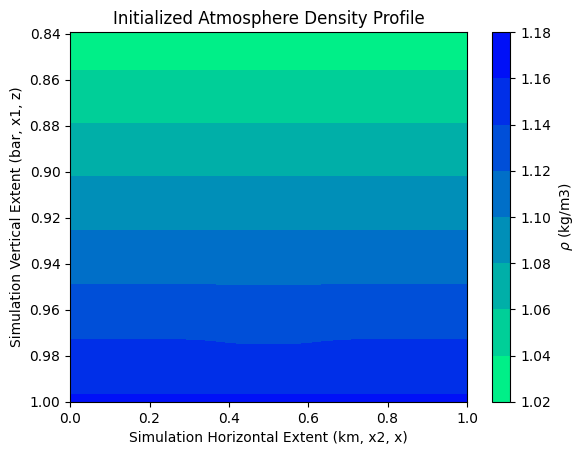

In [13]:
# Solve for air density
# Note that we use the full initialized temperature of the atmosphere
# with the bubble temperature anomaly: 

density = (P/(Rd*(T_array+delta_T)))

# Plot
plt.contourf(X/1000,P/1e5, density, cmap = 'winter_r',)
plt.gca().invert_yaxis()
plt.title(r'Initialized Atmosphere Density Profile')
plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
plt.ylabel('Simulation Vertical Extent (bar, x1, z)')
plt.colorbar(label = r'$\rho$ (kg/m3)')

<div class="alert alert-block alert-success">

Great! So we have a good idea how our bubble and its surrounding atmosphere is set up before we let it rise. 

Now lets go to **Part 2**, where we discuss the `.yaml` file and run the code. 